# Chapter 3: Inside Audio Transformers

**Following the [Hugging Face Audio Course](https://huggingface.co/learn/audio-course/) with proprietary sounds.**

The HF course Chapter 3 is pure theory: CTC vs Seq2Seq, encoder-only vs encoder-decoder, how audio enters a transformer. All essential, but no code.

This notebook makes it tangible. We will:

1. **Compare architectures**: load Wav2Vec2, Whisper, and AST side by side and inspect their structure
2. **Trace the data flow**: follow our thunder and chimes recordings through each model's internals
3. **Visualize attention**: see where Whisper "looks" when processing our soundscapes

Same theory, but now you can see it.

## Setup

In [1]:
!pip install -q transformers datasets librosa torch matplotlib seaborn

In [2]:
from google.colab import files
uploaded = files.upload()  # file picker

Saving thunder.wav to thunder.wav
Saving chimes.wav to chimes.wav


In [3]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

SR = 16000
thunder, _ = librosa.load("thunder.wav", sr=SR, mono=True)
chimes, _ = librosa.load("chimes.wav", sr=SR, mono=True)

# Use 5-second clips for all experiments
thunder_clip = thunder[:SR * 5]
chimes_clip = chimes[:SR * 5]

print(f"Thunder clip: {len(thunder_clip)/SR:.1f}s, {len(thunder_clip)} samples")
display(Audio(thunder_clip, rate=SR))
print(f"Chimes clip:  {len(chimes_clip)/SR:.1f}s, {len(chimes_clip)} samples")
display(Audio(chimes_clip, rate=SR))

Thunder clip: 5.0s, 80000 samples


Chimes clip:  5.0s, 80000 samples


---

## Part 1: Three Architectures, One Audio Clip

The HF course describes three architecture families for audio:

| Architecture | Type | Input | Example | Used for |
|---|---|---|---|---|
| **CTC** | Encoder-only | Raw waveform | Wav2Vec2 | ASR (speech to characters) |
| **Seq2Seq** | Encoder-decoder | Mel spectrogram | Whisper | ASR, captioning, translation |
| **Classification** | Encoder-only | Spectrogram patches | AST | Audio classification |

Let's load all three and look inside.

In [4]:
from transformers import (
    Wav2Vec2Model, Wav2Vec2FeatureExtractor,
    WhisperModel, WhisperFeatureExtractor,
    ASTModel, AutoFeatureExtractor,
)

# We need attn_implementation="eager" to extract attention weights.
# The default "sdpa" (scaled dot-product attention) is faster but
# does not support output_attentions=True.

print("Loading Wav2Vec2...")
w2v_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base", attn_implementation="eager")
w2v_fe = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

print("Loading Whisper...")
whisper_model = WhisperModel.from_pretrained("openai/whisper-tiny", attn_implementation="eager")
whisper_fe = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

print("Loading AST...")
ast_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
ast_fe = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

print("All models loaded.")

Loading Wav2Vec2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
project_hid.bias             | UNEXPECTED |  | 
project_q.bias               | UNEXPECTED |  | 
quantizer.codevectors        | UNEXPECTED |  | 
quantizer.weight_proj.weight | UNEXPECTED |  | 
quantizer.weight_proj.bias   | UNEXPECTED |  | 
project_q.weight             | UNEXPECTED |  | 
project_hid.weight           | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Loading Whisper...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/167 [00:00<?, ?it/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Loading AST...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

ASTModel LOAD REPORT from: MIT/ast-finetuned-audioset-10-10-0.4593
Key                         | Status     |  | 
----------------------------+------------+--+-
classifier.dense.weight     | UNEXPECTED |  | 
classifier.layernorm.weight | UNEXPECTED |  | 
classifier.dense.bias       | UNEXPECTED |  | 
classifier.layernorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

All models loaded.


### 1a. Parameter counts and structure

In [5]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

for name, model in [("Wav2Vec2-base", w2v_model), ("Whisper-tiny", whisper_model), ("AST", ast_model)]:
    total, trainable = count_params(model)
    print(f"\n{name}:")
    print(f"  Parameters: {total/1e6:.1f}M")
    print(f"  Type: {'encoder-decoder' if hasattr(model, 'decoder') else 'encoder-only'}")

    if hasattr(model, 'encoder') and hasattr(model.encoder, 'layers'):
        print(f"  Encoder layers: {len(model.encoder.layers)}")
    if hasattr(model, 'decoder') and hasattr(model.decoder, 'layers'):
        print(f"  Decoder layers: {len(model.decoder.layers)}")


Wav2Vec2-base:
  Parameters: 94.4M
  Type: encoder-only
  Encoder layers: 12

Whisper-tiny:
  Parameters: 37.8M
  Type: encoder-decoder
  Encoder layers: 4
  Decoder layers: 4

AST:
  Parameters: 86.2M
  Type: encoder-only


### 1b. How each model sees the same audio

Each model preprocesses audio differently. Let's see what they produce from the same 5-second clips.

In [6]:
for clip_name, clip in [("Thunder", thunder_clip), ("Chimes", chimes_clip)]:
    print(f"\n=== {clip_name} ===")

    w2v_inputs = w2v_fe(clip, sampling_rate=SR, return_tensors="pt")
    print(f"Wav2Vec2 input:  {w2v_inputs['input_values'].shape}")
    print(f"  raw waveform, {w2v_inputs['input_values'].shape[-1]} samples")

    whisper_inputs = whisper_fe(clip, sampling_rate=SR, return_tensors="pt")
    print(f"Whisper input:   {whisper_inputs['input_features'].shape}")
    print(f"  mel spectrogram, {whisper_inputs['input_features'].shape[1]} mel bins x {whisper_inputs['input_features'].shape[2]} time frames")

    ast_inputs = ast_fe(clip, sampling_rate=SR, return_tensors="pt")
    print(f"AST input:       {ast_inputs['input_values'].shape}")
    print(f"  spectrogram, {ast_inputs['input_values'].shape[1]} x {ast_inputs['input_values'].shape[2]}")


=== Thunder ===
Wav2Vec2 input:  torch.Size([1, 80000])
  raw waveform, 80000 samples
Whisper input:   torch.Size([1, 80, 3000])
  mel spectrogram, 80 mel bins x 3000 time frames
AST input:       torch.Size([1, 1024, 128])
  spectrogram, 1024 x 128

=== Chimes ===
Wav2Vec2 input:  torch.Size([1, 80000])
  raw waveform, 80000 samples
Whisper input:   torch.Size([1, 80, 3000])
  mel spectrogram, 80 mel bins x 3000 time frames
AST input:       torch.Size([1, 1024, 128])
  spectrogram, 1024 x 128


### 1c. What comes out: hidden states

In [7]:
results = {}

for clip_name, clip in [("Thunder", thunder_clip), ("Chimes", chimes_clip)]:
    print(f"\n=== {clip_name} ===")

    w2v_inputs = w2v_fe(clip, sampling_rate=SR, return_tensors="pt")
    whisper_inputs = whisper_fe(clip, sampling_rate=SR, return_tensors="pt")
    ast_inputs = ast_fe(clip, sampling_rate=SR, return_tensors="pt")

    with torch.no_grad():
        w2v_out = w2v_model(**w2v_inputs)
        whisper_enc_out = whisper_model.encoder(whisper_inputs['input_features'])
        ast_out = ast_model(**ast_inputs)

    print(f"Wav2Vec2:  {w2v_out.last_hidden_state.shape}")
    print(f"  {w2v_out.last_hidden_state.shape[1]} time steps x {w2v_out.last_hidden_state.shape[2]}d")
    print(f"  one vector per ~20ms, for CTC each predicts a character")

    print(f"Whisper:   {whisper_enc_out.last_hidden_state.shape}")
    print(f"  {whisper_enc_out.last_hidden_state.shape[1]} time steps x {whisper_enc_out.last_hidden_state.shape[2]}d")
    print(f"  the decoder cross-attends to this to generate tokens")

    print(f"AST:       {ast_out.last_hidden_state.shape}")
    print(f"  {ast_out.last_hidden_state.shape[1]} patches x {ast_out.last_hidden_state.shape[2]}d")
    print(f"  spectrogram split into 16x16 patches, like ViT")

    results[clip_name] = {
        'w2v': w2v_out.last_hidden_state[0].numpy(),
        'whisper': whisper_enc_out.last_hidden_state[0].numpy(),
        'ast': ast_out.last_hidden_state[0].numpy(),
    }


=== Thunder ===
Wav2Vec2:  torch.Size([1, 249, 768])
  249 time steps x 768d
  one vector per ~20ms, for CTC each predicts a character
Whisper:   torch.Size([1, 1500, 384])
  1500 time steps x 384d
  the decoder cross-attends to this to generate tokens
AST:       torch.Size([1, 1214, 768])
  1214 patches x 768d
  spectrogram split into 16x16 patches, like ViT

=== Chimes ===
Wav2Vec2:  torch.Size([1, 249, 768])
  249 time steps x 768d
  one vector per ~20ms, for CTC each predicts a character
Whisper:   torch.Size([1, 1500, 384])
  1500 time steps x 384d
  the decoder cross-attends to this to generate tokens
AST:       torch.Size([1, 1214, 768])
  1214 patches x 768d
  spectrogram split into 16x16 patches, like ViT


### 1d. Visual comparison

Hidden states as heatmaps: thunder vs chimes, across all three architectures.

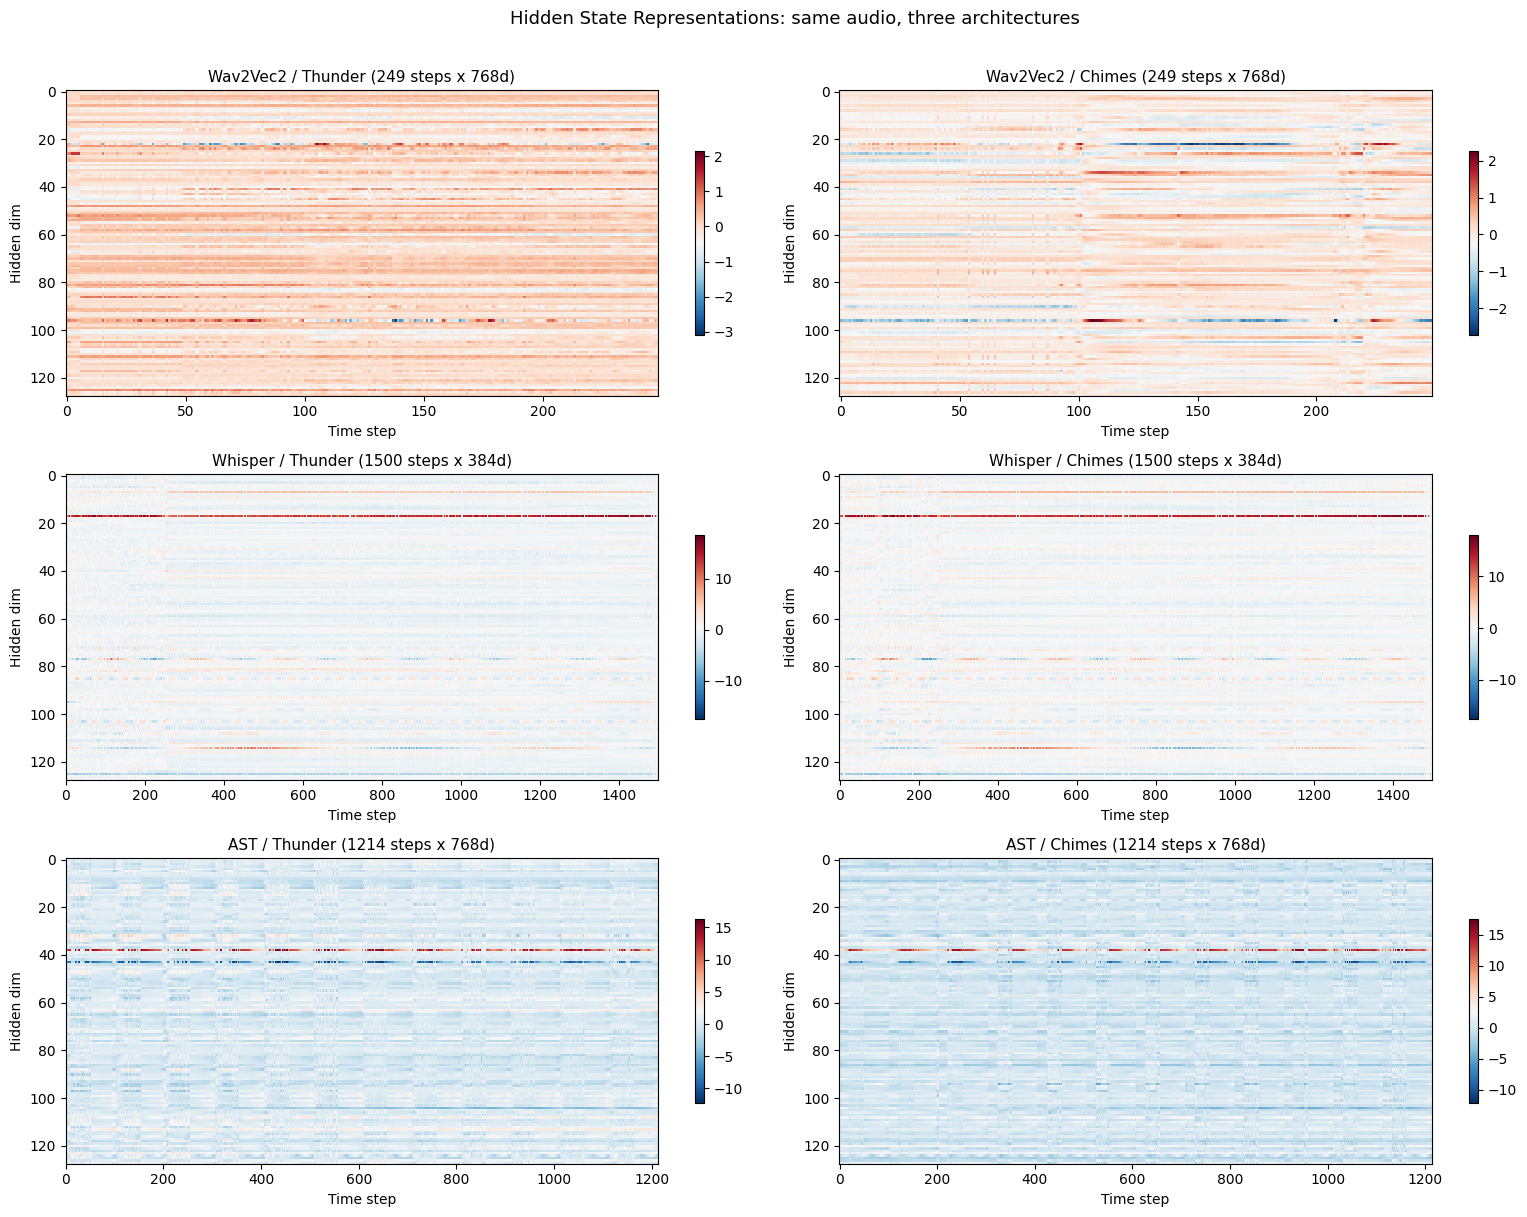

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

model_names = ["Wav2Vec2", "Whisper", "AST"]
model_keys = ['w2v', 'whisper', 'ast']
clip_names = ["Thunder", "Chimes"]

for row, (mname, mkey) in enumerate(zip(model_names, model_keys)):
    for col, cname in enumerate(clip_names):
        ax = axes[row, col]
        hidden = results[cname][mkey]
        im = ax.imshow(hidden[:, :128].T, aspect='auto', cmap='RdBu_r', interpolation='nearest')
        ax.set_title(f"{mname} / {cname} ({hidden.shape[0]} steps x {hidden.shape[1]}d)", fontsize=11)
        ax.set_ylabel("Hidden dim")
        ax.set_xlabel("Time step")
        plt.colorbar(im, ax=ax, shrink=0.6)

plt.suptitle("Hidden State Representations: same audio, three architectures", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

Each model creates a completely different representation of the same audio:
- **Wav2Vec2**: fine-grained (many time steps), learned directly from the raw waveform
- **Whisper**: coarser time resolution, derived from the mel spectrogram
- **AST**: patch-based, like a vision transformer looking at the spectrogram as an image

And notice how the same model produces visibly different representations for thunder vs chimes.

---

## Part 2: Inside Whisper, Encoder vs Decoder

Whisper is the most interesting to explore because it has both an encoder and a decoder. Let's trace the full data flow.

In [9]:
print("Whisper-tiny architecture:")
print(f"  Encoder: {len(whisper_model.encoder.layers)} layers, "
      f"{whisper_model.config.encoder_attention_heads} heads, "
      f"{whisper_model.config.d_model}d")
print(f"  Decoder: {len(whisper_model.decoder.layers)} layers, "
      f"{whisper_model.config.decoder_attention_heads} heads, "
      f"{whisper_model.config.d_model}d")
print(f"  Vocab size: {whisper_model.config.vocab_size}")
print(f"  Max source positions: {whisper_model.config.max_source_positions} (= 30s of audio)")
print(f"  Max target positions: {whisper_model.config.max_target_positions} (= max tokens to generate)")

Whisper-tiny architecture:
  Encoder: 4 layers, 6 heads, 384d
  Decoder: 4 layers, 6 heads, 384d
  Vocab size: 51865
  Max source positions: 1500 (= 30s of audio)
  Max target positions: 448 (= max tokens to generate)


In [10]:
for clip_name, clip in [("Thunder", thunder_clip), ("Chimes", chimes_clip)]:
    print(f"\n=== WHISPER DATA FLOW: {clip_name} ===")

    mel = whisper_fe(clip, sampling_rate=SR, return_tensors="pt")['input_features']
    print(f"1. Raw audio:        {clip.shape} ({len(clip)/SR:.1f}s at {SR}Hz)")
    print(f"2. Mel spectrogram:  {mel.shape} (batch=1, {mel.shape[1]} mel bins, {mel.shape[2]} frames)")
    print(f"   Whisper always pads/trims to 30s = 3000 frames")

    with torch.no_grad():
        enc_out = whisper_model.encoder(mel, output_attentions=True)

    print(f"3. Encoder output:   {enc_out.last_hidden_state.shape}")
    print(f"   1500 time steps (3000 frames / 2 from conv layers)")
    print(f"   Each step = {whisper_model.config.d_model}d vector representing ~20ms")
    print(f"   Encoder attentions: {len(enc_out.attentions)} layers")

    decoder_input = torch.tensor([[50258]])  # <|startoftranscript|>
    with torch.no_grad():
        dec_out = whisper_model.decoder(
            input_ids=decoder_input,
            encoder_hidden_states=enc_out.last_hidden_state,
            output_attentions=True,
        )

    print(f"4. Decoder output:   {dec_out.last_hidden_state.shape}")
    print(f"   Self-attention: decoder attends to its own previous tokens")
    print(f"   Cross-attention: decoder attends to encoder output (the audio)")
    print(f"   Cross-attention shape: {dec_out.cross_attentions[0].shape}")
    print(f"     = (batch, {dec_out.cross_attentions[0].shape[1]} heads, "
          f"{dec_out.cross_attentions[0].shape[2]} decoder tokens, "
          f"{dec_out.cross_attentions[0].shape[3]} encoder frames)")


=== WHISPER DATA FLOW: Thunder ===
1. Raw audio:        (80000,) (5.0s at 16000Hz)
2. Mel spectrogram:  torch.Size([1, 80, 3000]) (batch=1, 80 mel bins, 3000 frames)
   Whisper always pads/trims to 30s = 3000 frames
3. Encoder output:   torch.Size([1, 1500, 384])
   1500 time steps (3000 frames / 2 from conv layers)
   Each step = 384d vector representing ~20ms
   Encoder attentions: 4 layers
4. Decoder output:   torch.Size([1, 1, 384])
   Self-attention: decoder attends to its own previous tokens
   Cross-attention: decoder attends to encoder output (the audio)
   Cross-attention shape: torch.Size([1, 6, 1, 1500])
     = (batch, 6 heads, 1 decoder tokens, 1500 encoder frames)

=== WHISPER DATA FLOW: Chimes ===
1. Raw audio:        (80000,) (5.0s at 16000Hz)
2. Mel spectrogram:  torch.Size([1, 80, 3000]) (batch=1, 80 mel bins, 3000 frames)
   Whisper always pads/trims to 30s = 3000 frames
3. Encoder output:   torch.Size([1, 1500, 384])
   1500 time steps (3000 frames / 2 from conv lay

---

## Part 3: Visualizing Attention

This is the payoff. Two types of attention:

1. **Encoder self-attention**: how the model connects different parts of the audio
2. **Cross-attention**: how the decoder "looks at" the audio when generating each token

### 3a. Encoder self-attention

In [11]:
# Get encoder attention for both clips
enc_attentions = {}
for clip_name, clip in [("Thunder", thunder_clip), ("Chimes", chimes_clip)]:
    mel = whisper_fe(clip, sampling_rate=SR, return_tensors="pt")['input_features']
    with torch.no_grad():
        enc_out = whisper_model.encoder(mel, output_attentions=True)
    enc_attentions[clip_name] = enc_out.attentions

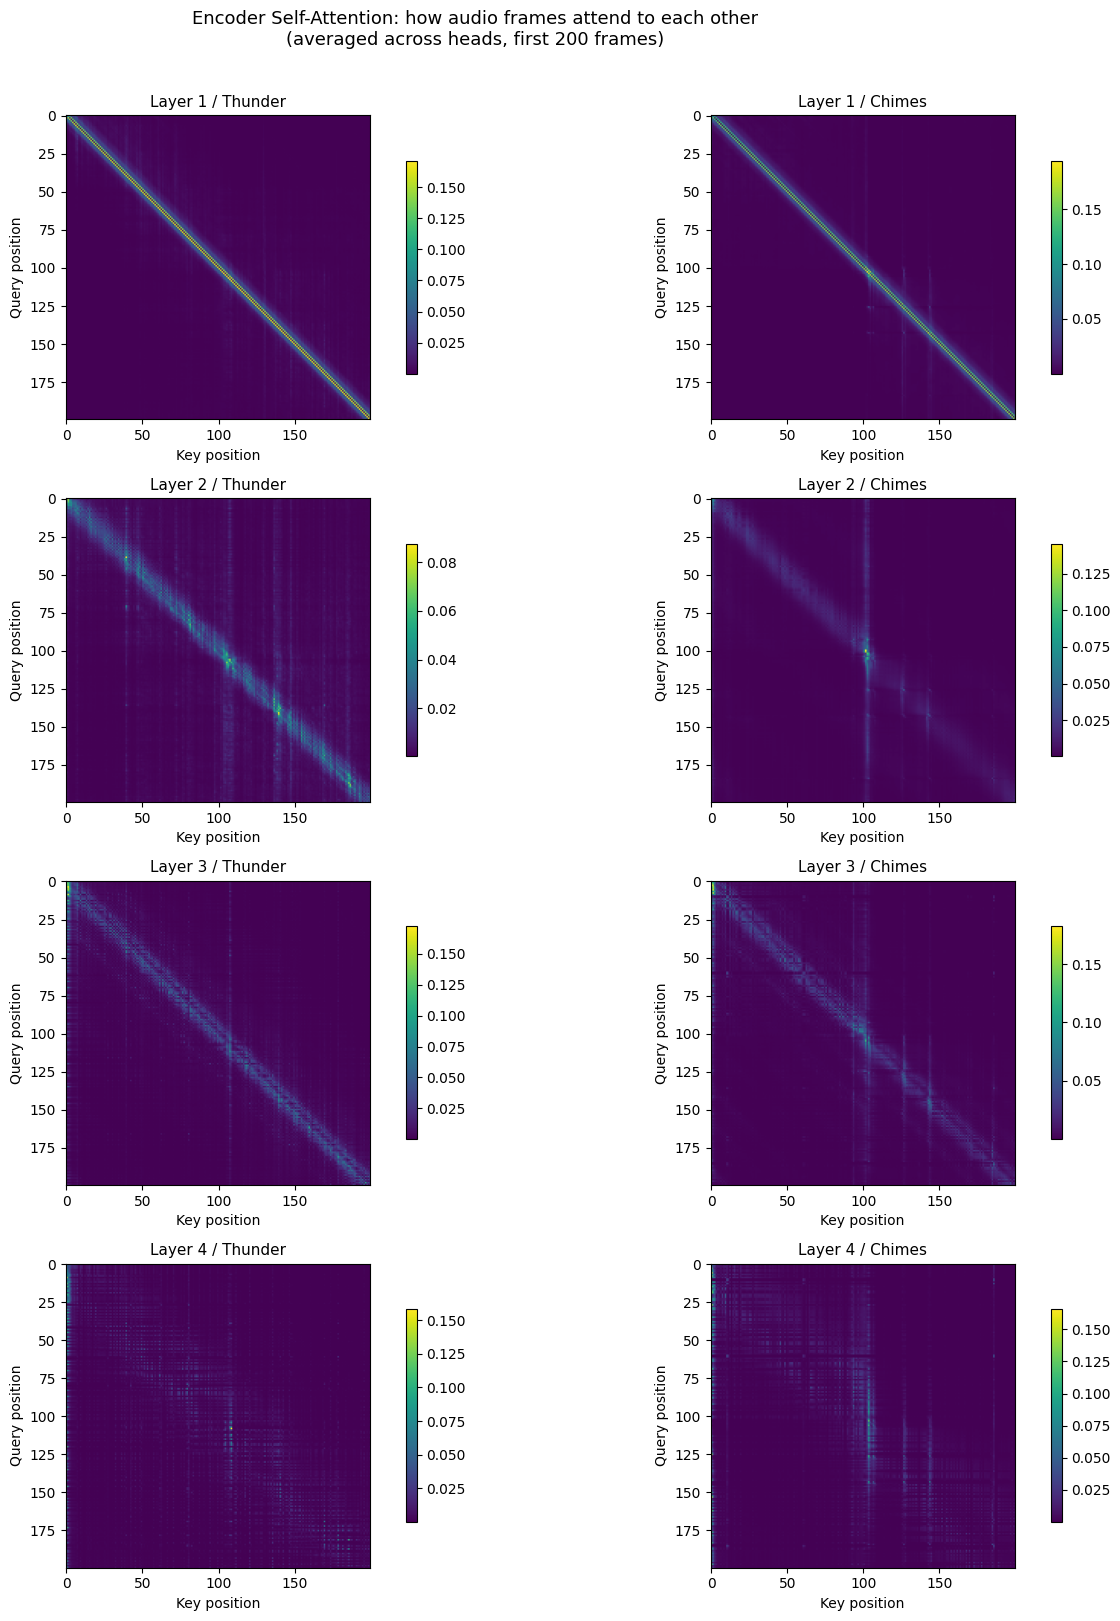

In [12]:
n_layers = len(enc_attentions["Thunder"])
fig, axes = plt.subplots(n_layers, 2, figsize=(14, 4 * n_layers))

window = 200  # first 200 time steps (~2.6s)

for row in range(n_layers):
    for col, clip_name in enumerate(["Thunder", "Chimes"]):
        ax = axes[row, col] if n_layers > 1 else axes[col]
        attn = enc_attentions[clip_name][row][0].mean(dim=0).numpy()
        im = ax.imshow(attn[:window, :window], cmap='viridis', aspect='equal')
        ax.set_title(f"Layer {row + 1} / {clip_name}", fontsize=11)
        ax.set_xlabel("Key position")
        ax.set_ylabel("Query position")
        plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("Encoder Self-Attention: how audio frames attend to each other\n"
             "(averaged across heads, first 200 frames)", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 3b. Individual attention heads

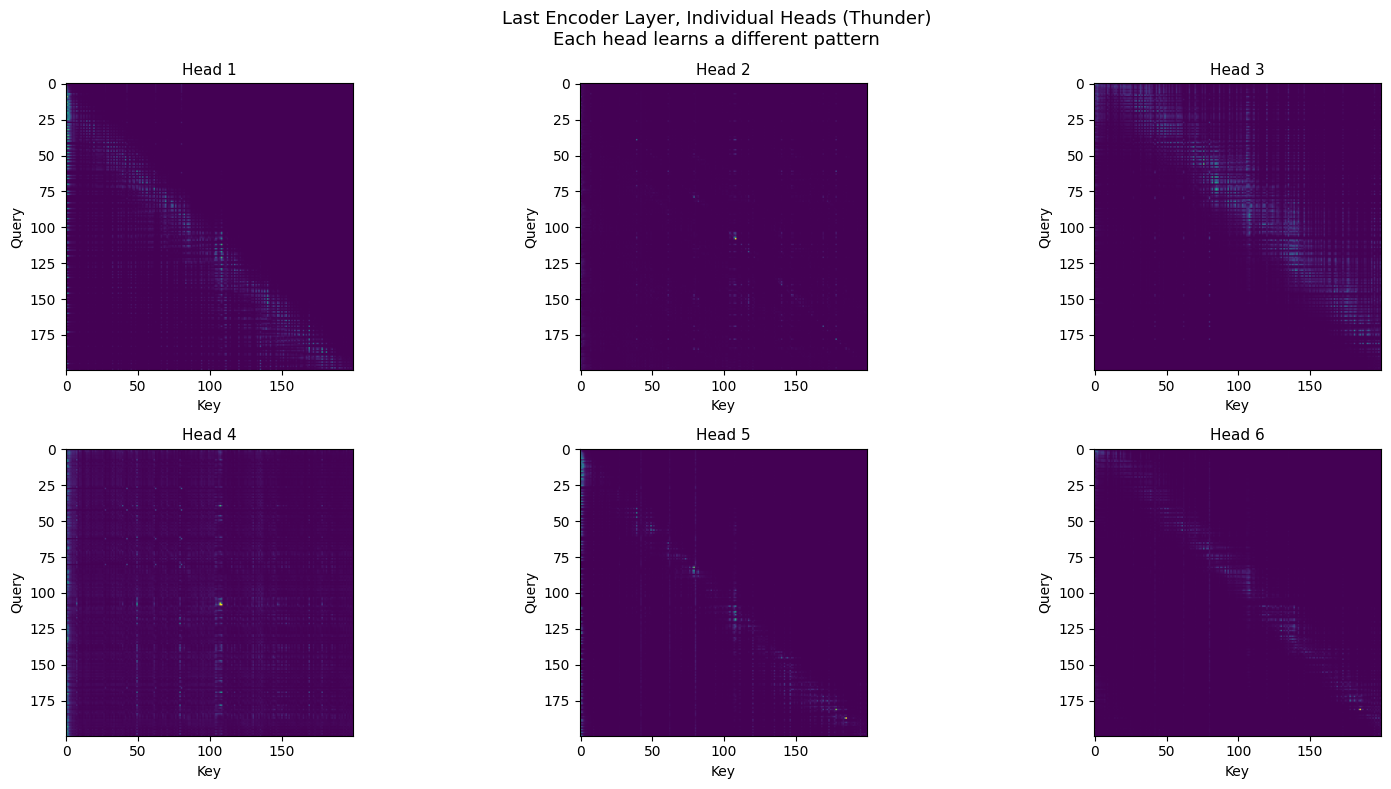

In [13]:
last_layer = n_layers - 1
n_heads = enc_attentions["Thunder"][last_layer].shape[1]

fig, axes = plt.subplots(2, n_heads // 2, figsize=(16, 8))
window = 200

for h in range(n_heads):
    ax = axes[h // (n_heads // 2), h % (n_heads // 2)]
    attn = enc_attentions["Thunder"][last_layer][0, h, :window, :window].numpy()
    ax.imshow(attn, cmap='viridis', aspect='equal')
    ax.set_title(f"Head {h + 1}", fontsize=11)
    ax.set_xlabel("Key")
    ax.set_ylabel("Query")

plt.suptitle(f"Last Encoder Layer, Individual Heads (Thunder)\n"
             f"Each head learns a different pattern", fontsize=13)
plt.tight_layout()
plt.show()

### 3c. Cross-attention: where the decoder looks

In [14]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
gen_model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny", attn_implementation="eager"
)
gen_model.eval()
print("Generation model loaded.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Loading weights:   0%|          | 0/167 [00:00<?, ?it/s]

generation_config.json: 0.00B [00:00, ?B/s]

Generation model loaded.


In [15]:
def get_cross_attention(audio_clip, sr=16000, max_tokens=50):
    """Run Whisper generation and return cross-attention matrix + generated text."""
    input_features = processor(audio_clip, sampling_rate=sr, return_tensors="pt").input_features

    with torch.no_grad():
        outputs = gen_model.generate(
            input_features,
            return_dict_in_generate=True,
            output_attentions=True,
            max_new_tokens=max_tokens,
        )

    text = processor.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
    tokens = [processor.tokenizer.decode([t]) for t in outputs.sequences[0].tolist()]

    n_steps = len(outputs.cross_attentions)
    last_layer = len(outputs.cross_attentions[0]) - 1

    cross_attn_matrix = []
    for step in range(n_steps):
        step_attn = outputs.cross_attentions[step][last_layer]
        avg = step_attn[0, :, -1, :].mean(dim=0)
        cross_attn_matrix.append(avg.numpy())

    cross_attn_matrix = np.stack(cross_attn_matrix)
    return cross_attn_matrix, tokens, text

In [16]:
thunder_10s = thunder[:SR * 10]
chimes_10s = chimes[:SR * 10]

thunder_ca, thunder_tokens, thunder_text = get_cross_attention(thunder_10s)
chimes_ca, chimes_tokens, chimes_text = get_cross_attention(chimes_10s)

print(f"Thunder: Whisper heard '{thunder_text}'")
print(f"  Tokens: {thunder_tokens}")
print(f"\nChimes: Whisper heard '{chimes_text}'")
print(f"  Tokens: {chimes_tokens}")

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
Passing `generation_config` together with generation-related arguments=({'output_attentions'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
The attention mask is not set and cannot be inferred from input because pad token is same as eos tok

Thunder: Whisper heard '.'
  Tokens: ['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', '.', '<|endoftext|>']

Chimes: Whisper heard ' you'
  Tokens: ['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', ' you', '<|endoftext|>']


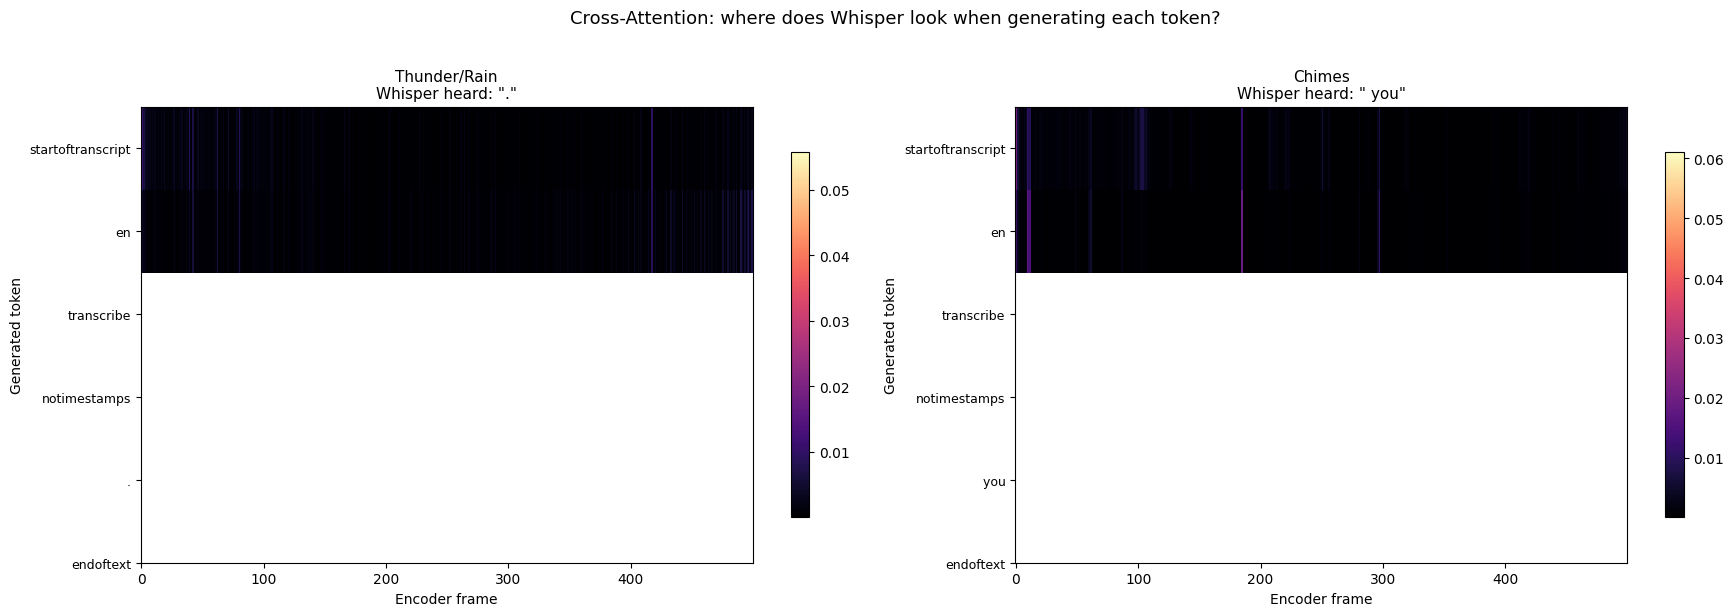

In [17]:
special_tokens = {'<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', '<|endoftext|>'}

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
show_frames = 500

for ax, (ca, tokens, text, title) in zip(axes, [
    (thunder_ca, thunder_tokens, thunder_text, "Thunder/Rain"),
    (chimes_ca, chimes_tokens, chimes_text, "Chimes"),
]):
    # Show all tokens including special ones. They reveal where the model
    # looks when deciding language, task, and when to stop.
    # Clean up token labels for readability
    labels = [t.replace('<|', '').replace('|>', '') for t in tokens]
    display_attn = ca[:, :show_frames]

    if display_attn.shape[0] > 0:
        im = ax.imshow(display_attn, aspect='auto', cmap='magma', interpolation='nearest')
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_xlabel("Encoder frame")
        ax.set_ylabel("Generated token")
        ax.set_title(f'{title}\nWhisper heard: "{text}"', fontsize=11)
        plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle("Cross-Attention: where does Whisper look when generating each token?", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### 3d. Attention over the spectrogram

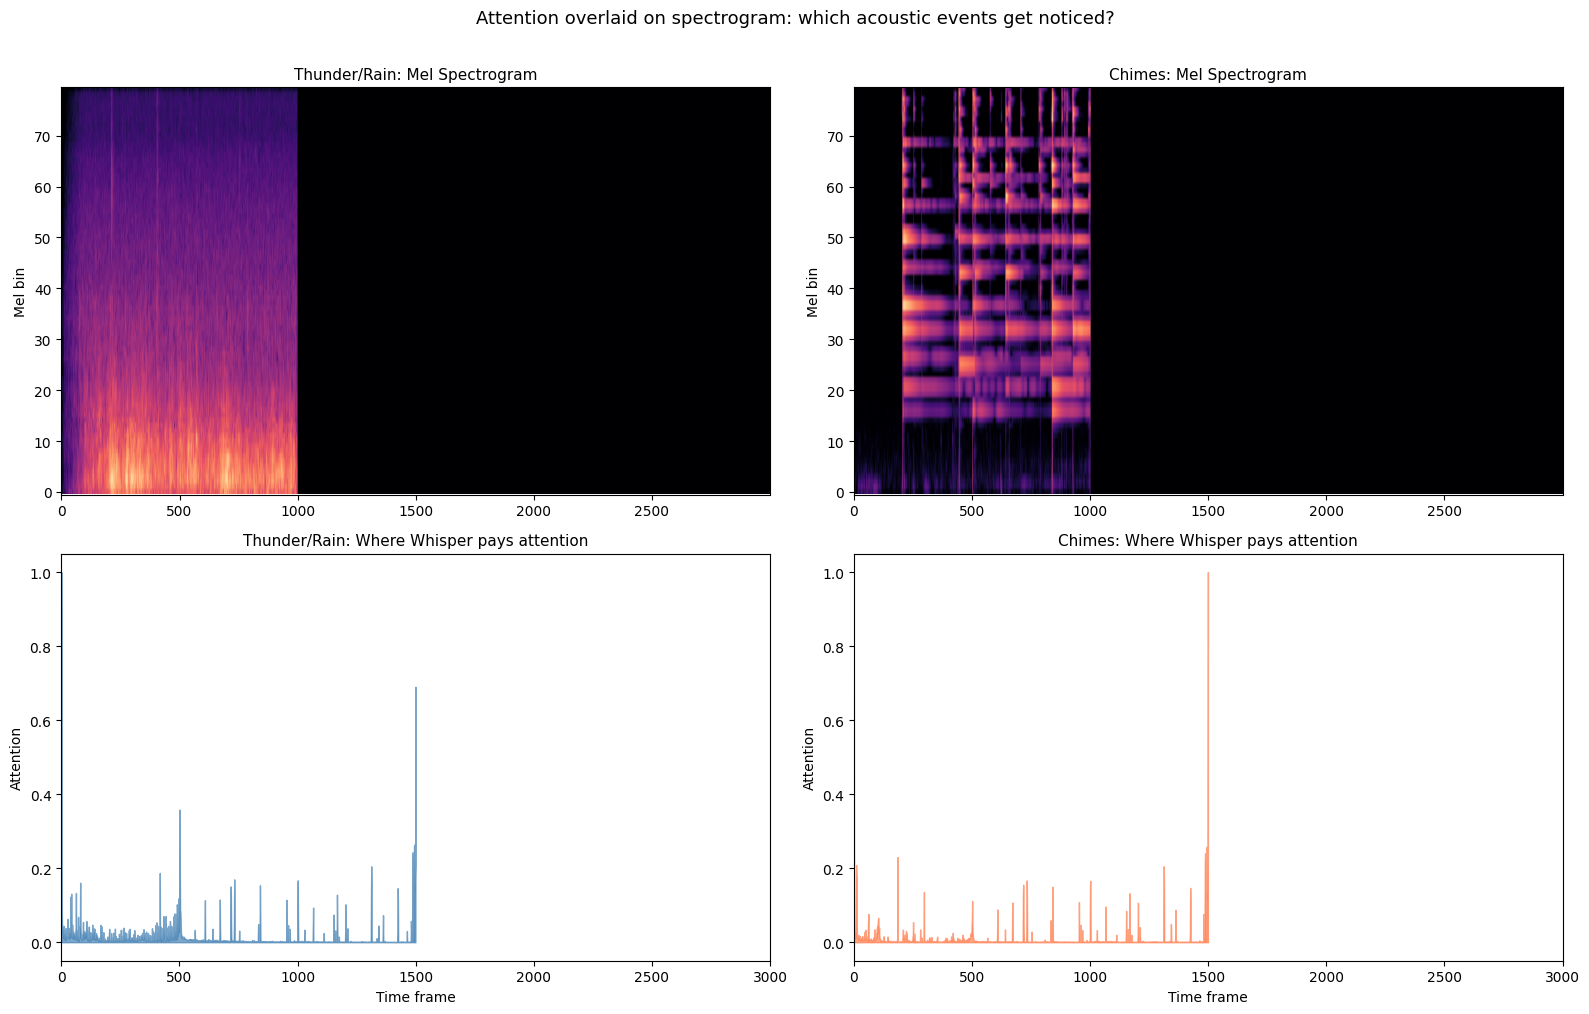

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for col, (clip_name, clip_10s, ca_matrix) in enumerate([
    ("Thunder/Rain", thunder_10s, thunder_ca),
    ("Chimes", chimes_10s, chimes_ca),
]):
    total_attention = ca_matrix.sum(axis=0)
    total_attention = total_attention / total_attention.max()

    mel_spec = whisper_fe(clip_10s, sampling_rate=SR, return_tensors="pt")['input_features'][0].numpy()

    axes[0, col].imshow(mel_spec, aspect='auto', origin='lower', cmap='magma')
    axes[0, col].set_ylabel('Mel bin')
    axes[0, col].set_title(f'{clip_name}: Mel Spectrogram', fontsize=11)

    axes[1, col].fill_between(range(len(total_attention)), total_attention, alpha=0.7,
                              color='steelblue' if col == 0 else 'coral')
    axes[1, col].set_xlim(0, mel_spec.shape[1])
    axes[1, col].set_ylabel('Attention')
    axes[1, col].set_xlabel('Time frame')
    axes[1, col].set_title(f'{clip_name}: Where Whisper pays attention', fontsize=11)

plt.suptitle('Attention overlaid on spectrogram: which acoustic events get noticed?', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

Compare the two: thunder/rain has continuous energy spread across the clip, while chimes have distinct transient events. The attention profiles reflect this.

Whisper is a speech model trying to process environmental sounds. The attention patterns tell us what the model finds "interesting" even when the input isn't speech.

---

## Recap

| What we explored | What we learned |
|---|---|
| **3 architectures** (Wav2Vec2, Whisper, AST) | Same audio, completely different representations |
| **Input formats** | Raw waveform vs mel spectrogram vs spectrogram patches |
| **Encoder self-attention** | Early layers = local, deeper layers = global |
| **Attention heads** | Each head specializes in a different pattern |
| **Cross-attention** | Where the decoder "looks" when generating each token |
| **Attention + spectrogram** | Links attention to actual acoustic events |

The theory from HF Course Chapter 3 is essential reading. This notebook puts it in your hands.

### Next: Chapter 4

We fine-tune our own audio classifier on environmental sounds.

---

📖 **Theory**: [HF Audio Course, Unit 3](https://huggingface.co/learn/audio-course/en/chapter3/introduction)